In [62]:
%matplotlib inline

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from plot_sklearn_dendrogram import plot_sklearn_dendrogram # local python file to view dendrogram
from scipy import stats
from math import floor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import graphviz

Our data are separated into two datasets : 
 - The first one will be used for clustering. It gathers information on four variables for each country : 
 The government health expenditures (% of GNI), the Food Deficit (kcal/day/pers), the life expectancy (years) and the natural ressources rents (% of GNI)
 - The second one contains complementary information that will be added to the previous dataset for the classification. Three variables will be added : 
 The surface area (m²), the population and the GNI (US \$)

# Import data

### GNI | Surface | Population dataset

In [64]:
dfgni = pd.read_csv("GNI_Surface_Data.txt",sep="\t",header=0)
dfgni = dfgni.dropna()

In [65]:
dfgni.head()

,Time,Time Code,Country Name,Country Code,Surface,Population,GNI
0,2010,YR2010,Afghanistan,AFG,652860.0,28803167,1.599880e+10
1,2010,YR2010,Bangladesh,BGD,148460.0,152149102,1.246171e+11
2,2010,YR2010,Bhutan,BTN,38394.0,727641,1.497492e+09
3,2010,YR2010,India,IND,3287260.0,1230980691,1.638663e+12
4,2010,YR2010,Maldives,MDV,300.0,364511,2.276923e+09


In [66]:
len(dfgni)

193

After removing all rows with missing values, we have 193 countries left, which is enough to complete our analysis.

### clustering dataset

We will use this dataset for the clustering.

In [67]:
dfautres = pd.read_csv("autres_Data.txt",sep="\t",header=0)
dfautres = dfautres.dropna()

In [68]:
dfautres.head()

,Time,Time Code,Country Name,Country Code,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents
0,2010,YR2010,Afghanistan,AFG,2.255471,158.0,61.226,0.732845
1,2010,YR2010,Bangladesh,BGD,4.071213,119.0,70.198,1.309144
3,2010,YR2010,India,IND,3.169405,115.0,66.625,4.671042
4,2010,YR2010,Maldives,MDV,13.603584,79.0,76.112,0.008966
5,2010,YR2010,Nepal,NPL,4.802811,74.0,67.914,1.470750


In [69]:
len(dfautres)

112

This time there were a few more rows with missing values, but once all removed we still have more than 100 countries. Assuming that we don't remove too much outliers, this number should be enough for our analysis

### additional data for classification 

In [70]:
classification2 = pd.read_csv("additional_Data.txt",sep="\t",header=0)
classification2 = classification2.dropna()

In [71]:
classification2.head()

,Time,Time Code,Country Name,Country Code,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization
0,2010,YR2010,Afghanistan,AFG,0.293837,31.7,101383.0,50.046191,5.1,62.0
1,2010,YR2010,Albania,ALB,1.578574,18.6,423.0,88.089492,7.8,99.0
2,2010,YR2010,Algeria,DZA,3.299704,15.4,23676.0,92.388330,3.3,95.0
5,2010,YR2010,Angola,AGO,1.243406,18.1,122844.0,40.057690,5.7,67.0
6,2010,YR2010,Antigua and Barbuda,ATG,5.539568,21.6,16.0,97.088704,0.3,98.0


In [72]:
len(classification2)

182

There are enough coutries to complete our classification dataset.

# Merge datasets

We now merge the three datasets (dfgni, dfautres, classification2) according to the country code, in order to obtain a full dataset to use for the classification.

In [73]:
data = pd.merge(dfgni, dfautres, how='inner', on=['Country Name', 'Country Code'])

In [74]:
data=data.drop(columns=['Time_x', 'Time Code_x', 'Time_y', 'Time Code_y'])

In [75]:
dataComplet = pd.merge(data, classification2, how='inner', on=['Country Name', 'Country Code'])

In [76]:
dataComplet=dataComplet.drop(columns=['Time','Time Code' ])

In [77]:
dataComplet.loc[:,'under_five_deaths']=dataComplet.loc[:,'under_five_deaths']/(dataComplet.loc[:,'Population']//100000)

Since the number of deaths of infants (<5yo) is given directly for each country, we decided to convert it : it will now indicate the number of infant deaths for 100,000 inhabitants (same unit as suicide rate)

In [78]:
# set index with country code
data = data.set_index('Country Code')
dataComplet = dataComplet.set_index('Country Code')

In [79]:
dataComplet.head()

,Country Name,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization
Country Code,,,,,,,,,,,,,,
AFG,Afghanistan,652860.0,28803167,1.599880e+10,2.255471,158.0,61.226,0.732845,0.293837,31.7,352.024306,50.046191,5.1,62.0
BGD,Bangladesh,148460.0,152149102,1.246171e+11,4.071213,119.0,70.198,1.309144,0.393937,22.2,105.285996,96.502332,6.4,88.0
IND,India,3287260.0,1230980691,1.638663e+12,3.169405,115.0,66.625,4.671042,1.397009,24.2,125.549435,85.262912,16.5,82.0
MDV,Maldives,300.0,364511,2.276923e+09,13.603584,79.0,76.112,0.008966,2.565314,16.7,30.666667,98.191641,3.2,97.0
NPL,Nepal,147180.0,27023137,1.612497e+10,4.802811,74.0,67.914,1.470750,0.187128,23.8,110.233333,85.149949,10.5,86.0


In [80]:
len(dataComplet)

111

There are enough coutries left.

# Boxplots visualization

We will now use a normalisation of our data column by column, so we can visualize and detect outliers

### clustering dataset (dfautres)

In [86]:
# set index with country code
dfautresn = dfautres
dfautresn = dfautresn.set_index('Country Code')

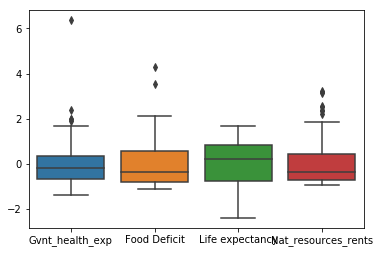

In [87]:
# boxplot of the clustering data
dfautresn = dfautresn.iloc[:,3:]
Z_scored_dfautres = (dfautresn-dfautresn.mean())/dfautresn.std()
sns.boxplot(data=Z_scored_dfautres)

### classification dataset (dataComplet)

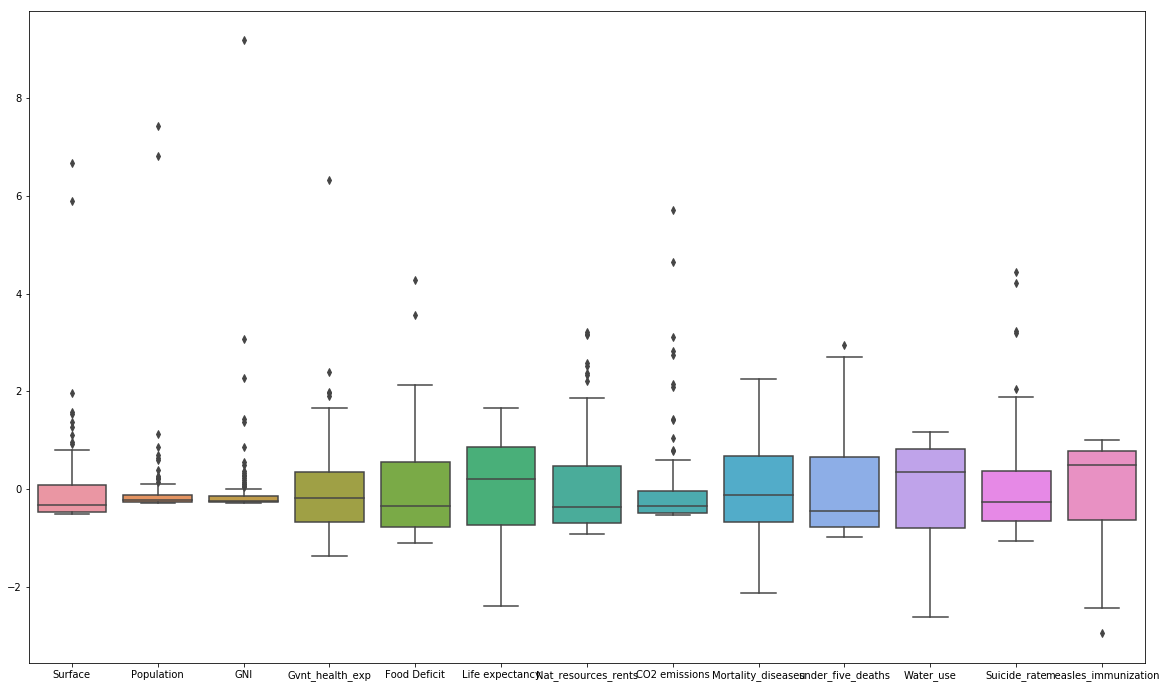

In [89]:
# boxplot with the whole dataset (classification)
plt.figure(figsize=(20,12))
datan = dataComplet.iloc[:,1:]
Z_scored_df = (datan-datan.mean())/datan.std()
sns.boxplot(data=Z_scored_df)

# Outliers detection

As we could previously see, some values seem to be out of range, and might have an influence on our future classification and clusters. We defined a threshold, so that all values above it should be considered as an outlier and removed from the dataset.

## dfautres

In [90]:
dfautresn.mean(axis=0) # mean for each variable

Gvnt_health_exp          8.378800
Food Deficit           112.348214
Life expectancy         66.760248
Nat_resources_rents     10.867296
dtype: float64

In [91]:
threshold = 2.5
mask = np.abs(dfautresn) > dfautresn.mean()+threshold*dfautresn.std()
outliers = dfautresn[mask.any(axis=1)]

In [92]:
mask.any()

Gvnt_health_exp         True
Food Deficit            True
Life expectancy        False
Nat_resources_rents     True
dtype: bool

In [93]:
mask.loc[sorted(list(set(outliers.index)))]

,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents
Country Code,,,,
BLZ,True,False,False,False
COG,False,False,False,True
HTI,False,True,False,False
IRQ,False,False,False,True
KWT,False,False,False,True
MRT,False,False,False,True
SAU,False,False,False,True
ZMB,False,True,False,False


The previous countries are considered as outliers, according to our threshold, but different variables are impacted. Since we would like to keep the oil-producing countries in our analysis, we decided to ignore outliers that are only related to this variable. As to the 3 remaining, we decided to remove them, so our final dataset contains 109 countries.

In [94]:
maskbis=mask.iloc[:,:3]
outliersbis = dfautresn[maskbis.any(axis=1)]

In [95]:
dfautrestri = dfautresn.loc[sorted(list(set(dfautresn.index).difference(set(outliersbis.index))))]

In [96]:
len(dfautrestri)

109

Even after removing the outliers, we have enough countries left to run our analysis.

## dataComplet

We repeat the same procedure on the dataset used for classification

In [97]:
datan.mean(axis=0) # mean for each variable

Surface                 6.831314e+05
Population              4.859118e+07
GNI                     1.777908e+11
Gvnt_health_exp         8.391488e+00
Food Deficit            1.116667e+02
Life expectancy         6.681770e+01
Nat_resources_rents     1.095765e+01
CO2 emissions           3.166801e+00
Mortality_diseases      2.142883e+01
under_five_deaths       1.708307e+02
Water_use               7.886848e+01
Suicide_rate            8.101802e+00
measles_immunization    8.554054e+01
dtype: float64

In [98]:
threshold = 2.5
mask2 = np.abs(datan) > datan.mean()+threshold*datan.std()
outliers2 = datan[mask2.any(axis=1)]

In [99]:
mask2.any()

Surface                  True
Population               True
GNI                      True
Gvnt_health_exp          True
Food Deficit             True
Life expectancy         False
Nat_resources_rents      True
CO2 emissions            True
Mortality_diseases      False
under_five_deaths        True
Water_use               False
Suicide_rate             True
measles_immunization    False
dtype: bool

As we previously did, we ignore the outliers related to natural ressources rent

In [100]:
mask2bis=mask2.iloc[:,:6]
outliers2bis = datan[mask2bis.any(axis=1)]
outliers2bis

,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization
Country Code,,,,,,,,,,,,,
IND,3287260.0,1230980691,1.638663e+12,3.169405,115.0,66.625,4.671042,1.397009,24.2,125.549435,85.262912,16.5,82.0
CHN,9562911.0,1337705000,6.074549e+12,9.447319,108.0,75.236,6.249178,6.560520,18.1,20.103386,90.849655,10.9,99.0
ZMB,752610.0,13850033,1.890254e+10,3.313305,455.0,56.588,21.387444,0.194337,19.9,324.949275,57.107193,6.3,96.0
BLZ,22970.0,321608,1.239593e+09,41.644164,36.0,69.676,4.992062,1.676106,23.2,47.666667,93.918681,4.9,98.0
BRA,8515770.0,196796269,2.144024e+12,8.392290,17.0,73.838,4.452136,2.132938,19.0,29.126080,96.258078,5.7,99.0
HTI,27750.0,9999617,6.644822e+09,2.545283,524.0,61.296,1.192176,0.212694,22.3,589.121212,62.108173,10.2,64.0


We decided to remove both Haïti and Zambia, because they appear as outliers for our Food Deficit indicator, which is already given in kilocalories per person per day. As for the others outliers, we decided to calculate Density instead of keeping Surface and Population, and divided GNI by the population, so that it is expressed as a ratio of the total population.

In [101]:
# Density calculation
datanbis=datan.copy(deep=True)
Density=datanbis.iloc[:,1]/datanbis.iloc[:,0]
datanbis.iloc[:,2]=datanbis.iloc[:,2]/datanbis.iloc[:,1]
datanbis=datanbis.drop(columns="Population")

In [102]:
# add De,sity to the dataset
datanbis.iloc[:,0]=Density
datanbis=datanbis.rename({"Surface":"Density"}, axis='columns')
len(datanbis)

111

In [103]:
# outliers detection
threshold = 2.5
mask3 = np.abs(datanbis) > datanbis.mean()+threshold*datanbis.std()
outliers3 = datanbis[mask3.any(axis=1)]
# we keep outliers not related to nat. ressources
mask3=mask3.iloc[:,:5]
outliers3 = datanbis[mask3.any(axis=1)]

In [104]:
mask3.loc[sorted(list(set(outliers3.index)))]

,Density,GNI,Gvnt_health_exp,Food Deficit,Life expectancy
Country Code,,,,,
ARE,False,True,False,False,False
BGD,True,False,False,False,False
BLZ,False,False,True,False,False
BRB,True,False,False,False,False
BRN,False,True,False,False,False
HTI,False,False,False,True,False
KWT,False,True,False,False,False
MDV,True,False,False,False,False
MUS,True,False,False,False,False


As there are even more outliers with transformed data, we decided to keep the former dataframe and remove the outliers previously identified (outliers2bis).

In [105]:
datatri = datan.loc[sorted(list(set(datan.index).difference(set(outliers2bis.index))))]

In [106]:
len(datatri)

105

There are enough countries left to run our classification.

# Correlation



## clustering dataset

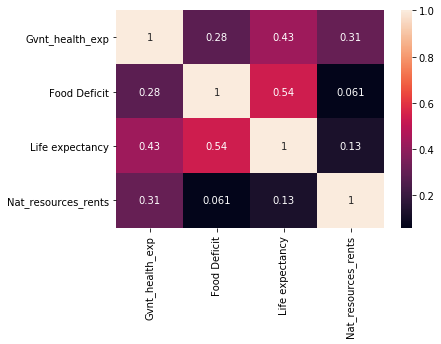

In [107]:
sns.heatmap(abs(dfautrestri.corr()),annot=True)

We can see that the Life expectancy values are correlated both to the Food deficit values and to the Government health expenditure values. From that first test, we can say that countries with a lower food deficit and with higher health expenditures tend to have a higher life expectancy.

## classification dataset

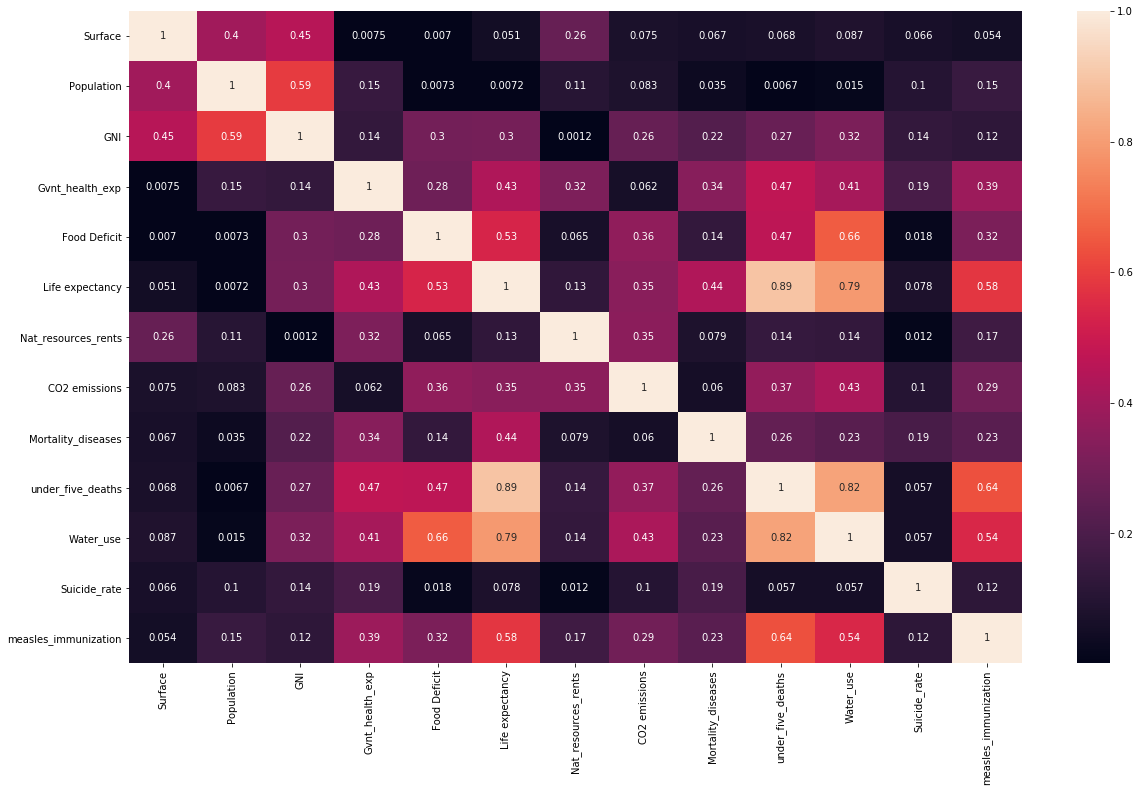

In [108]:
plt.figure(figsize=(20,12))
sns.heatmap(abs(datatri.corr()),annot=True)

Again, we can see that Life Expectancy is very correlated to different variables, which is normal as this point as we will create groups from their difference in Life expenctancy, and try to predict those groups thanks to the other variables. Other variables like Food Deficit and water use are also correlated. In the classification analysis, we will check that the correlations don't cause overfitting, and eventually remove correlated variables.

# Normalize data 

## clustering dataset

In [45]:
Z_dfautrestri = (dfautrestri - dfautrestri.mean())/dfautrestri.std()

## classification dataset

In [109]:
Z_datatri = (datatri - datatri.mean())/datatri.std()

# Clustering (dfautrestri)

## Hierarchical clustering

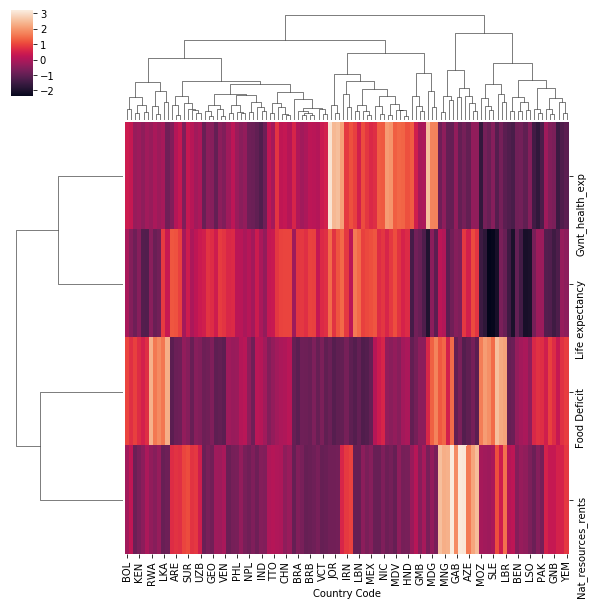

In [49]:
sns.clustermap(Z_dfautrestri.T,method='complete')

It seems that the clusters are characterized mostly by life expectancy and government health expenditure. However, we would like to have a more precise description.

## Agglomerative clustering

In order to do so, we decided to run an agglomerative clustering algorithm. We decided to generate 4 clusters as it seemed to be a reasonnable amount of clusters to describe our data, but we will later verify that this amount of clusters is coherent.

In [118]:
agc = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
agc.fit(Z_dfautrestri)
        
dffdv = Z_dfautrestri.values # get the data matrix of values (dataframe feature data values)
clustersAgglo = (agc.labels_+1)*100 #cluster labels for each point
AggloLabels = map(str,sorted(set(clustersAgglo.tolist())))
AggloLabels

['100', '200', '300', '400']

In [119]:
Z_dfautrestri2=Z_dfautrestri.copy()

In [120]:
Z_dfautrestri2=Z_dfautrestri2.assign(cluster=clustersAgglo)

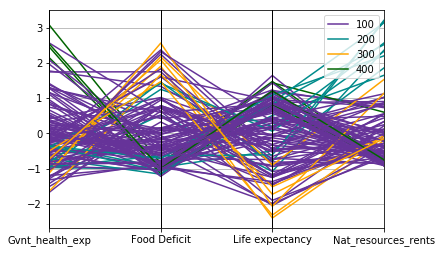

In [124]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri2,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen'))
plt.show()

Thanks to the parallel coordinate visualization, we can see how the variables discriminate the four clusters:
it seems that there is a first group of countries with a high Food Deficit and a low Life Expectancy values (yellow). A second group of countries with low Government health expenditures and high naturanl ressources rents is represented in green. The two other groups are a bit confused, and don't seem to show a tendency. Only the Government health expenditures discriminate the purple cluster from the green one.


In [125]:
# to get feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(Z_dfautrestri, clustersAgglo)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [126]:
# feature importance
rf.feature_importances_

array([0.19459602, 0.14315337, 0.15526704, 0.50698357])

We can see that "Natural Ressources rents" is the most important feature, used to discriminate the counttries into 4 groups, which is probably due to the presence of oil producing countries.

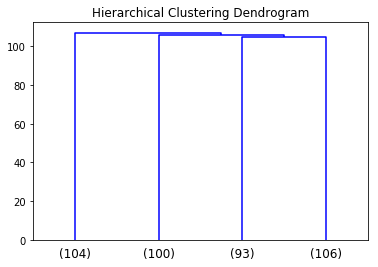

In [127]:
plt.title('Hierarchical Clustering Dendrogram')
plot_sklearn_dendrogram(agc, labels=agc.labels_, truncate_mode='lastp', p=4) #cf plot_sklearn_dendrogram.py
plt.show()

This dendogram shows us that with 4 clusters, the countries are evenly distributed into 4 groups.

In [128]:
# silhouette score
metrics.silhouette_score(dffdv, clustersAgglo, metric='euclidean', sample_size=None) # sample_size=None for no sampling 

0.17086809792513927

Finally, the silhouette coeficient score calculated for this clustering isn't good enough : it should be closer to 1 in order to be acceptable. This means that the clusters given by agglomerative method are not perfect, wich is probably because alla the countries represented in purple are not well dictinguished : only two of the 4 clusters are really well established.

## Kmeans

Before actually runing the Kmeans method on our data, we used the SSE and the silhouette coefficient in order to figure out the number of clusters we had generate. We also run a stability analysis to see if the algorithm is stable with the number of clusters we wanted.

In [133]:
## test du nombre de cluster:
SSE = [] #stockage des SSE pour chaque nombre de cluster
silh = [] #stockage des coeff silhouettes pour chaque nombre de cluster
for i in range(2,10):
    kmeans = KMeans(i)
    kmeans = kmeans.fit(Z_dfautrestri)
    Z_dfautrestri["cluster"] = kmeans.predict(Z_dfautrestri)
    SSE.append(kmeans.inertia_)
    silh.append(metrics.silhouette_score(Z_dfautrestri, Z_dfautrestri["cluster"], metric='euclidean', sample_size=None))

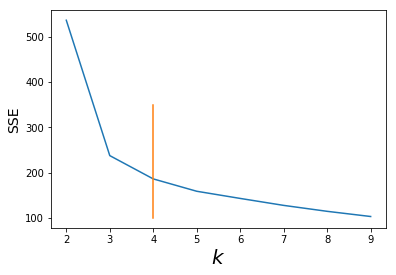

In [134]:
## graphe de la SSE:
plt.plot(range(2,10),SSE)
plt.plot([4,4],[100,350])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("SSE",fontsize=14)

According to SSE, we can choose between 3 or 4 clusters.

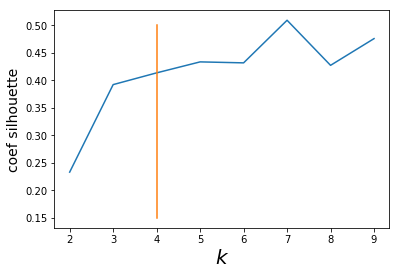

In [135]:
## coeff silhouette:
plt.plot(range(2,10),silh)
plt.plot([4,4],[0.15,0.5])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("coef silhouette",fontsize=14)

The silhouette coeficient is slightly better with 4 clusters.

### Stability

In [158]:
silhouette_coef = []
sse = []
k = 4
n_init=1
for i in range(100):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=i) # create a KMeans object
    km.fit(Z_dfautrestri)
    labels = km.predict(Z_dfautrestri)
    sse.append(km.inertia_)
    silhouette_coef.append(metrics.silhouette_score(Z_dfautrestri, labels, metric='euclidean', sample_size=None))

(array([77.,  0.,  0.,  2.,  9.,  3.,  4.,  1.,  1.,  3.]),
 array([182.84897362, 189.41831958, 195.98766554, 202.55701149,
        209.12635745, 215.69570341, 222.26504937, 228.83439533,
        235.40374129, 241.97308725, 248.54243321]),
 <a list of 10 Patch objects>)

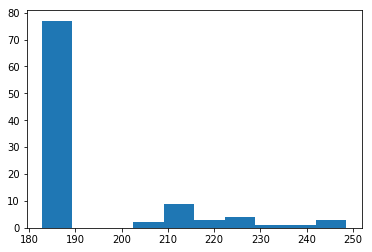

In [159]:
plt.hist(sse)

(array([ 1.,  0.,  3.,  1.,  0.,  2.,  6.,  3.,  3., 81.]),
 array([0.25470706, 0.27292002, 0.29113297, 0.30934593, 0.32755888,
        0.34577183, 0.36398479, 0.38219774, 0.4004107 , 0.41862365,
        0.43683661]),
 <a list of 10 Patch objects>)

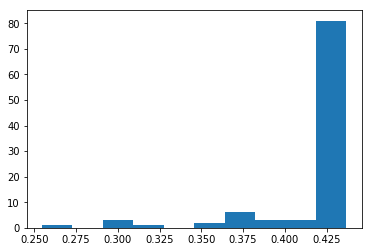

In [160]:
plt.hist(silhouette_coef)

According to the shape of the distributions above, we can say kmeans clustering is quite stable with 4 clusters, as we obtain the same values in the majority of the cases.

In [157]:
def compute_stability(k,df,iterations=100):
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(metrics.silhouette_score(df, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

In [152]:
stability = []
Ks = range(2,30)
for k in Ks:
    stability.append(compute_stability(k,Z_dfautrestri))

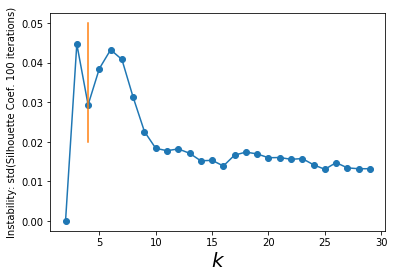

In [153]:
plt.plot(Ks,stability,"o-")
plt.plot([4,4],[0.02,0.050])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("Instability: std(Silhouette Coef. 100 iterations)")

4 cluters seems like a good compromise between a low instability and a reasonable amount of clusters.

### KMeans clustering ATTENTION : ne pas relancer les cases suivantes qui concernent kmeans

In [192]:
# final clustering
from sklearn.cluster import KMeans
kmeans = KMeans(4)
kmeans = kmeans.fit(Z_dfautrestri)
Z_dfautrestri["cluster"] = kmeans.predict(Z_dfautrestri)

In [193]:
metrics.silhouette_score(Z_dfautrestri, Z_dfautrestri["cluster"], metric='euclidean', sample_size=None)

0.40580661965765136

As expected, the silhouette score is better than the one we obtained with the previous clustering method

In [194]:
sse = kmeans.inertia_
print("sse =", sse)

('sse =', 182.84897361643652)


In [195]:
KLabels = map(str,sorted(set(kmeans.predict(Z_dfautrestri).tolist())))
KLabels

['0', '1', '2', '3']

### Parallel coordinates method to represent the clustered data

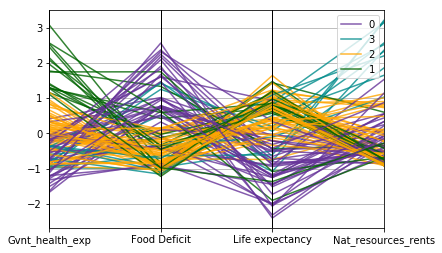

In [196]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen'),alpha=0.8)
plt.show()

As we can see on this representation, the clusters are well discriminated, and we can easily identify 4 groups, unlike the clusters given by the agglomerativ method previously used.

### Use a decision Tree to Describe the Clusters

In order to get a complementary characterization, we used a Decision Tree to describe the clusters. A max_depth of 3 seemed like a good compromise between a low entropy and the number of sample per leaves

In [197]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix

In [198]:
dt = DecisionTreeClassifier(max_depth=3,criterion="entropy")
prediction_features = [c for c in Z_dfautrestri.columns if c != "cluster"]
dt = dt.fit(Z_dfautrestri[prediction_features],Z_dfautrestri["cluster"])

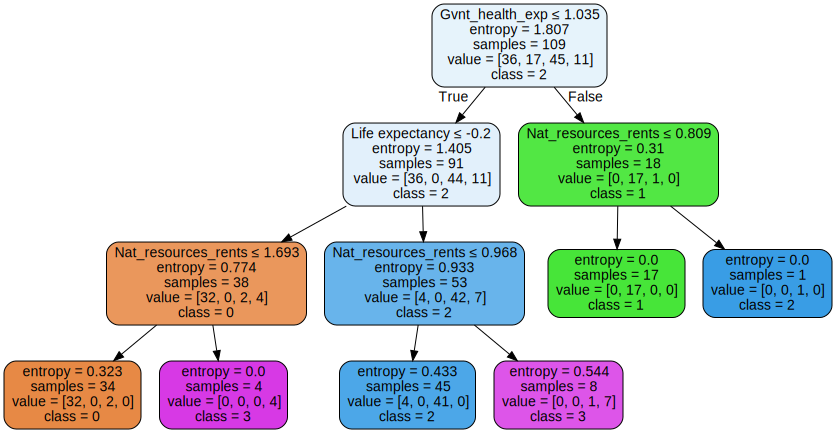

In [199]:
dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=prediction_features,  
                         class_names=["0","1","2","3"], # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

In this instance, we can see how the different classes are characterized: 
- class 0 : low life expectancy with somewhat low natural resources rents
- class 1 : high government health expenditure with low natural resources rents
- class 2 : somewhat low government health expenditure and natural resources rents with high life expectancy
- class 3 : low government health expenditure with high natural resources rents 

We can also visualize the clusters described above with the pairplots below:

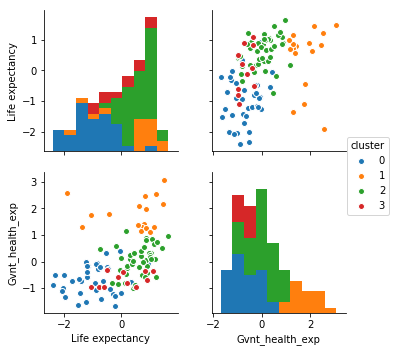

In [202]:
sns.pairplot(Z_dfautrestri,vars=["Life expectancy","Gvnt_health_exp"],hue="cluster")

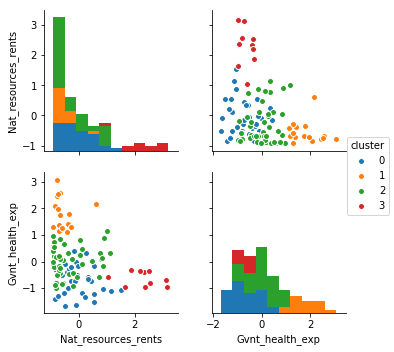

In [203]:
sns.pairplot(Z_dfautrestri,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

## DBSCAN

We then decided to try a second clustering method, that we could compare to Kmeans afterwards.

In [204]:
dbscan = DBSCAN(eps=0.9, min_samples=5)
dbscan.fit(Z_dfautrestri)

DBSCAN(algorithm='auto', eps=0.9, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [205]:
values = Z_dfautrestri.values 
clustersDBS = dbscan.labels_
clustersDBS=(clustersDBS+2)*10
Z_dfautrestri3=Z_dfautrestri.copy()
Z_dfautrestri3=Z_dfautrestri3.assign(cluster=clustersDBS)

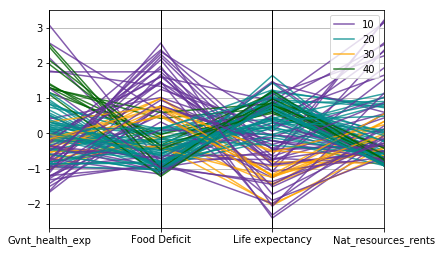

In [206]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri3,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen','black'),alpha=0.8)
plt.show()

In [207]:
metrics.silhouette_score(values, clustersDBS, metric='euclidean', sample_size=None) # sample_size=None for no sampling 

0.1494256338794496

With DBSCAN, the silhouette coeficient is again very low, but the clusters still seems more defined than the ones we had with the agglomerative method, according to the representation above.

In [208]:
DBSCANLabels = map(str,sorted(set(clustersDBS.tolist())))
DBSCANLabels

['10', '20', '30', '40']

## Comparing the different clustering methods

### Confusion matrix

#### Kmeans vs DBscan

In [209]:
allLabels = KLabels + DBSCANLabels
allLabels

['0', '1', '2', '3', '10', '20', '30', '40']

In [210]:
cm1 = metrics.confusion_matrix(Z_dfautrestri["cluster"].astype(str), clustersDBS.astype(str),labels=allLabels)
cm1.shape

(8, 8)

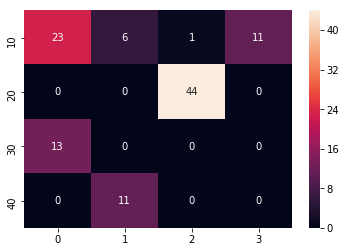

In [211]:
cmdf1 = pd.DataFrame(data=cm1, copy=True, index=allLabels, columns=allLabels).loc[KLabels, DBSCANLabels]
cmdf1 = cmdf1.transpose()
sns.heatmap(cmdf1, annot=True)

The confusion matric shows us that clusters 2 and 20 (resp. from Kmeans and DBSCAN) are alike, whereas cluster 10 is a combination of clusters 0, 1 and 3. The repartition of the countries according to the 2 algorithms isn't quite the same. DBSCAN generated 2 small clusters and 2 big clusters, and Kmeans's clusters are more evenly distributed, althought one cluster is smaller.

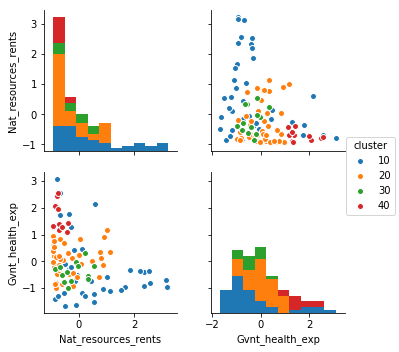

In [212]:
# DBSCAN clusters representation
sns.pairplot(Z_dfautrestri3,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

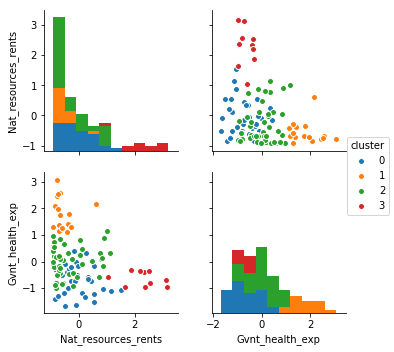

In [213]:
# Kmeans clusters representation
sns.pairplot(Z_dfautrestri,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

The DBSCAN clusters seem to be a bit more "confused" than the Kmeans clusters, but we can still identify 4 groups.

#### Kmeans vs Agglomerative clusterring

We repeated the same procedure to compare Kmeans and Agglomerative clusters.

In [214]:
allLabels2 = KLabels + AggloLabels
allLabels2

['0', '1', '2', '3', '100', '200', '300', '400']

In [215]:
cm2 = metrics.confusion_matrix(Z_dfautrestri["cluster"].astype(str), clustersAgglo.astype(str),labels=allLabels2)
cm2.shape

(8, 8)

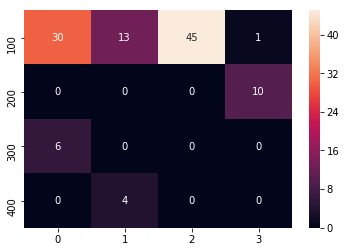

In [216]:
cmdf2 = pd.DataFrame(data=cm2, copy=True, index=allLabels2, columns=allLabels2).loc[KLabels, AggloLabels]
cmdf2 = cmdf2.transpose()
sns.heatmap(cmdf2, annot=True)

The difference between the two methods is even bigger than the previous comparison. Agglomerative clustering gave one big cluster and only 3 very small groups with extreme values, which is coherent with an agglomarative representation of the data, and well illustrated by the representation below :

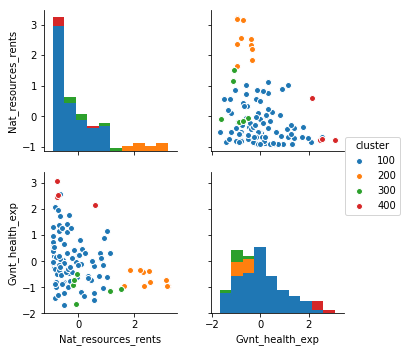

In [217]:
sns.pairplot(Z_dfautrestri2,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

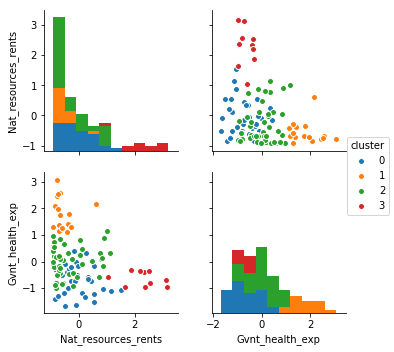

In [218]:
sns.pairplot(Z_dfautrestri,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

### Entropy

#### Kmeans vs DBscan

In [219]:
proba = 0.1*cmdf1.values/cmdf1.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
print(proba)
entropy = [stats.entropy(row, base=2) for row in proba]
print "entropy of each cluster:", entropy

[[0.05609756 0.01463415 0.00243902 0.02682927]
 [0.         0.         0.1        0.        ]
 [0.1        0.         0.         0.        ]
 [0.         0.1        0.         0.        ]]
entropy of each cluster: [1.5135166924559253, 0.0, 0.0, 0.0]


#### Kmeans vs Agglomerative clusterring

In [220]:
proba = 0.1*cmdf2.values/cmdf2.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
print(proba)
entropy = [stats.entropy(row, base=2) for row in proba]
print "entropy of each cluster:", entropy

[[0.03370787 0.01460674 0.0505618  0.0011236 ]
 [0.         0.         0.         0.1       ]
 [0.1        0.         0.         0.        ]
 [0.         0.1        0.         0.        ]]
entropy of each cluster: [1.5044320428885873, 0.0, 0.0, 0.0]


# Classification

As we briefly explained before, we decided to create classes amoung the countries, according to their Life expectancy values, and we will try to predict them thanks to the remaining variables, all more or less connected or having an effect on the Life expectancy value of a country.

## Construct the labels

#### Manually defined labels

In [422]:
sort_datatri=Z_datatri.sort_values('Life expectancy') # sort the normalized data
n=len(sort_datatri)

At first, we decided to manually construct three classes by dividing the countries into 3 even groups :
    - class 1 : low life expectancy
    - class 2 : medium life expectancy
    - class 3 : high life expectancy

In [423]:
x=np.array(['1','2','3']) # array needed to create the classes array
classes=np.repeat(x, floor(n/3))

In [424]:
sort_datatri=sort_datatri.assign(classe=classes) # assign each country to a class
sort_datatri=sort_datatri.drop(labels='Life expectancy', axis=1)
sort_datatri.head()

,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization,classe
Country Code,,,,,,,,,,,,,
CAF,0.173244,-0.516499,-0.484739,-0.896960,1.890275,-0.216027,-0.538246,0.664492,2.322118,-1.386408,0.245358,-2.414426,1
SLE,-0.678952,-0.465482,-0.481514,-0.504129,1.456573,-0.071594,-0.529242,1.992194,2.752904,-1.506809,0.194744,-0.246995,1
TCD,1.196196,-0.327710,-0.440886,-1.126899,2.540828,1.105086,-0.540935,0.587524,3.003387,-2.061531,0.110387,-2.937599,1
CIV,-0.291821,-0.111628,-0.368721,-1.002936,-0.049336,-0.392889,-0.490374,1.376449,1.411942,-0.339187,0.785241,-1.143863,1
LSO,-0.743856,-0.577612,-0.479314,-0.526034,-0.362566,-0.621074,-0.358977,1.068576,0.671570,-0.488584,2.033722,0.201439,1


#### Labels defined by a KMeans clustering

Then we also tried to create more accurate classes : each country will be distributed into a class by a Kmeans algorithm.

In [425]:
kmeans = KMeans(3)
kmeans = kmeans.fit(Z_datatri.loc[:,"Life expectancy"].values.reshape(-1, 1))
classes2= kmeans.predict(Z_datatri.loc[:,"Life expectancy"].values.reshape(-1, 1)).astype(str) 
sort_datatri2=sort_datatri.copy()
sort_datatri2=sort_datatri.assign(classe=classes2) # assign each country to a class
sort_datatri2.head()

,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization,classe
Country Code,,,,,,,,,,,,,
CAF,0.173244,-0.516499,-0.484739,-0.896960,1.890275,-0.216027,-0.538246,0.664492,2.322118,-1.386408,0.245358,-2.414426,2
SLE,-0.678952,-0.465482,-0.481514,-0.504129,1.456573,-0.071594,-0.529242,1.992194,2.752904,-1.506809,0.194744,-0.246995,0
TCD,1.196196,-0.327710,-0.440886,-1.126899,2.540828,1.105086,-0.540935,0.587524,3.003387,-2.061531,0.110387,-2.937599,1
CIV,-0.291821,-0.111628,-0.368721,-1.002936,-0.049336,-0.392889,-0.490374,1.376449,1.411942,-0.339187,0.785241,-1.143863,1
LSO,-0.743856,-0.577612,-0.479314,-0.526034,-0.362566,-0.621074,-0.358977,1.068576,0.671570,-0.488584,2.033722,0.201439,1


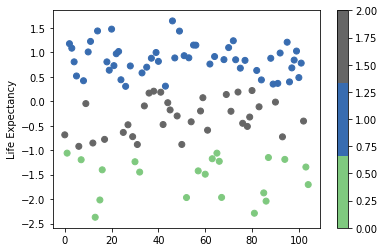

In [426]:
# Visualization of the three clusters in term of Life expectancy
Z_datatri_copy=Z_datatri.copy() 
Z_datatri_copy=Z_datatri_copy.assign(classe=classes2) # assigned each coutry to a class
plt.scatter(range(len(Z_datatri_copy.loc[:,"Life expectancy"].values)),Z_datatri_copy.loc[:,"Life expectancy"].values,c=classes2,cmap=plt.cm.get_cmap("Accent", 3))
plt.ylabel("Life Expectancy")
plt.colorbar()
plt.show()

We can see that we have three classe defined by:
    - class 0 : low life expectancy
    - class 2 : medium life expectancy
    - class 1 : high life expectancy

All the country are evenly distributed into 3 classes of similar size.

## KNN Classification

###  KNN Classification with the manually defined labels

In [329]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
data_train, data_test, label_train, label_test = train_test_split(sort_datatri, classes, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes)))

In [330]:
# knn model
model = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

In [331]:
# Training
model.fit(data_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [332]:
# Testing
label_predict = model.predict(data_test)
print('accuracy = ', metrics.accuracy_score(label_test, label_predict))
print(metrics.classification_report(label_test, label_predict))

('accuracy = ', 0.6857142857142857)
             precision    recall  f1-score   support

          1       0.62      1.00      0.76         8
          2       0.64      0.50      0.56        14
          3       0.82      0.69      0.75        13

avg / total       0.70      0.69      0.68        35



In [333]:
# Confusion matrix
import pandas as pds
pds.DataFrame(
    metrics.confusion_matrix(y_true=label_test, y_pred=label_predict, labels=sortedLabelList),
    columns=['Predicted ' + str(className) for className in sortedLabelList],
    index=['True ' + str(className) for className in sortedLabelList]
)

,Predicted 1,Predicted 2,Predicted 3
True 1,8,0,0
True 2,5,7,2
True 3,0,4,9


Both accuracy and precision are about $0.70$, which is quite high. Moreover, we can see that for the class 1, everything is perfectly predicted. However, the other two classes have some misclassification.

#### Cross-validation

In [334]:
from sklearn.model_selection import StratifiedKFold,cross_validate
scoring = ['accuracy', 'precision_weighted',  'recall_weighted',  'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(model, sort_datatri, classes, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00089788, 0.00336385, 0.00142622, 0.00102186, 0.0011611 ,
        0.0007751 , 0.00085497, 0.00079608]),
 'score_time': array([0.00290513, 0.00350499, 0.00285578, 0.00275612, 0.00268102,
        0.00278902, 0.00254798, 0.00255585]),
 'test_accuracy': array([0.66666667, 0.93333333, 0.66666667, 0.83333333, 0.75      ,
        0.91666667, 0.83333333, 0.75      ]),
 'test_f1_weighted': array([0.67424242, 0.93265993, 0.65723906, 0.82222222, 0.74285714,
        0.91534392, 0.83809524, 0.74285714]),
 'test_precision_weighted': array([0.72222222, 0.94444444, 0.65555556, 0.88888889, 0.77777778,
        0.93333333, 0.88888889, 0.77777778]),
 'test_recall_weighted': array([0.66666667, 0.93333333, 0.66666667, 0.83333333, 0.75      ,
        0.91666667, 0.83333333, 0.75      ])}

Through the cross-validation process, we can see that the scoring metrics remain quite high. 

#### Testing overfitting

We want now to see whether there is any overfitting.

In [335]:
# variation of the number of neighbours
train_accuracy = []
test_accuracy = []
for i in range(1,30):
    model_i = neighbors.KNeighborsClassifier(n_neighbors=i, weights='uniform', p=2)
    # Training
    model_i.fit(data_train, label_train)
    train_predict = model_i.predict(data_train)
    # Testing
    test_predict = model_i.predict(data_test)
    train_accuracy.append(metrics.accuracy_score(label_train, train_predict))
    test_accuracy.append(metrics.accuracy_score(label_test, test_predict))

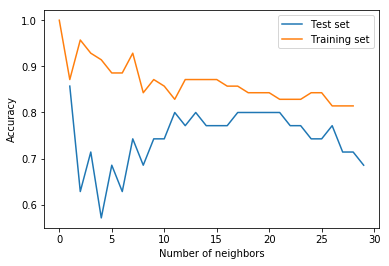

In [336]:
# plot of the training and testing accuracy vs the number of neighbors
plt.plot(range(1,30), test_accuracy, label="Test set")
plt.plot(train_accuracy, label="Training set")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Number of neighbors")

We can see that, as the number of neighbors increases, the test accuracy and training accuracies grow closer. Thus, there does not seem to be any overfitting. Furthermore, the accuracy remains quite high.

## KNN Classification with the kmeans labels

In [380]:
data_train, data_test, label_train, label_test = train_test_split(sort_datatri2, classes2, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes2)))

In [381]:
# knn model
model_knn_2 = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

In [382]:
# Training
model_knn_2.fit(data_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [383]:
# Testing
label_predict = model_knn_2.predict(data_test)
print('accuracy = ', metrics.accuracy_score(label_test, label_predict))
print(metrics.classification_report(label_test, label_predict))

('accuracy = ', 0.5142857142857142)
             precision    recall  f1-score   support

          0       0.52      0.94      0.67        16
          1       0.00      0.00      0.00        12
          2       1.00      0.43      0.60         7

avg / total       0.44      0.51      0.42        35



In [384]:
# Confusion matrix
import pandas as pds
pds.DataFrame(
    metrics.confusion_matrix(y_true=label_test, y_pred=label_predict, labels=sortedLabelList),
    columns=['Predicted ' + str(className) for className in sortedLabelList],
    index=['True ' + str(className) for className in sortedLabelList]
)

,Predicted 0,Predicted 1,Predicted 2
True 0,15,1,0
True 1,12,0,0
True 2,2,2,3


Both accuracy and precision are quite low with values around $0.50$. In addition, we can see in the confusion matrix that there were not any true prediction for the class 1.

#### Cross-validation

In [390]:
from sklearn.model_selection import StratifiedKFold,cross_validate
scoring = ['accuracy', 'precision_weighted','recall_weighted', 'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(model_knn_2, sort_datatri2, classes2, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00096703, 0.00164819, 0.00121403, 0.00078082, 0.00079298,
        0.00079107, 0.00081015, 0.00099397]),
 'score_time': array([0.00272202, 0.00297785, 0.00264287, 0.00274014, 0.00279093,
        0.00259495, 0.00294185, 0.00290203]),
 'test_accuracy': array([0.6       , 0.78571429, 0.71428571, 0.38461538, 0.30769231,
        0.58333333, 0.5       , 0.75      ]),
 'test_f1_weighted': array([0.57755991, 0.76428571, 0.67843137, 0.34265734, 0.27455621,
        0.56481481, 0.44444444, 0.74175824]),
 'test_precision_weighted': array([0.64666667, 0.82321429, 0.70714286, 0.31868132, 0.24908425,
        0.55      , 0.44444444, 0.74603175]),
 'test_recall_weighted': array([0.6       , 0.78571429, 0.71428571, 0.38461538, 0.30769231,
        0.58333333, 0.5       , 0.75      ])}

We can see that the different metrics vary greatly from one kind of partition to another.

#### Testing overfitting

In [391]:
# variation of the number of neighbours
train_accuracy = []
test_accuracy = []
for i in range(1,30):
    model_i = neighbors.KNeighborsClassifier(n_neighbors=i, weights='uniform', p=2)
    # Training
    model_i.fit(data_train, label_train)
    train_predict = model_i.predict(data_train)
    # Testing
    test_predict = model_i.predict(data_test)
    train_accuracy.append(metrics.accuracy_score(label_train, train_predict))
    test_accuracy.append(metrics.accuracy_score(label_test, test_predict))

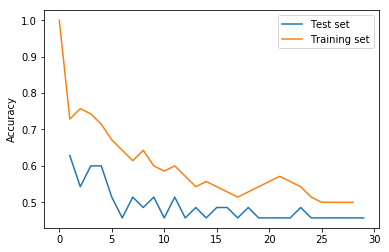

In [393]:
plt.plot(range(1,30),test_accuracy, label="Test set")
plt.plot(train_accuracy, label="Training set")
plt.legend()
plt.ylabel("Accuracy")

We can see that, as the number of neighbors increases, the test accuracy and training accuracy grow closer. Thus, there does not seem to be any overfitting. Nonetheless, the accuracy remains quite low.

## Decision Tree with manual labels

In [617]:
data=sort_datatri.drop(labels='classe', axis=1)
data_train, data_test, label_train, label_test = train_test_split(data, classes, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes)))
dt = DecisionTreeClassifier(max_depth=3,criterion="entropy")
dt = dt.fit(data_train,label_train)
tree_predict=dt.predict(data_test)

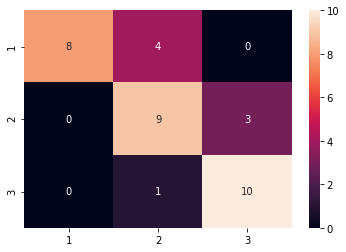

In [618]:
cm3 = metrics.confusion_matrix(label_test, tree_predict)
cm3.shape
cmdf3 = pd.DataFrame(data=cm3, copy=True,index=sortedLabelList,columns=sortedLabelList).loc[sortedLabelList,sortedLabelList]
cmdf3 = cmdf3.transpose()
sns.heatmap(cmdf3, annot=True)

In [619]:
metrics.accuracy_score(label_test,tree_predict)

0.7714285714285715

As the confusion matrix and accuracy score show, the decision tree algorithm succeeded to classify our data according to the manually-made labels. This means the variables were sufficient to discriminate the countries and predict their life expectancy level. 

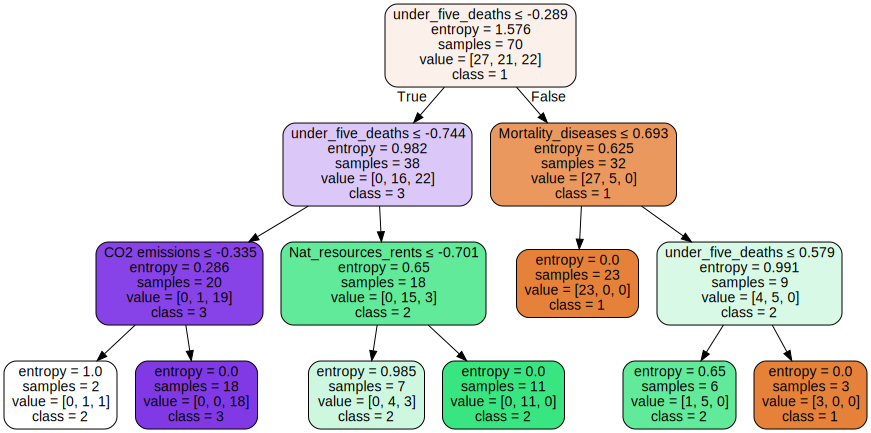

In [621]:
dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=data.columns,  
                         class_names=sortedLabelList, # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

Here we can see how the countries were distributed into the 3 classes.

#### Cross-validation

In [622]:
scoring = ['accuracy', 'precision_weighted',  'recall_weighted',  'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(dt, data, classes, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00152588, 0.00133014, 0.00118089, 0.00117207, 0.00109386,
        0.00110698, 0.00099492, 0.00118709]),
 'score_time': array([0.00199199, 0.00158596, 0.00141811, 0.00128603, 0.00119615,
        0.00117302, 0.00123096, 0.00119805]),
 'test_accuracy': array([0.8       , 0.93333333, 0.73333333, 0.75      , 0.75      ,
        0.75      , 0.83333333, 0.75      ]),
 'test_f1_weighted': array([0.7979798 , 0.93265993, 0.71572872, 0.6962963 , 0.74285714,
        0.70909091, 0.83201058, 0.74074074]),
 'test_precision_weighted': array([0.80555556, 0.94444444, 0.8015873 , 0.82222222, 0.77777778,
        0.85714286, 0.85      , 0.8       ]),
 'test_recall_weighted': array([0.8       , 0.93333333, 0.73333333, 0.75      , 0.75      ,
        0.75      , 0.83333333, 0.75      ])}

#### Testing overfitting

In [623]:
accuracy_train = []
accuracy_test = []
for i in range(2,20):
    dt = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    dt = dt.fit(data_train,label_train)
    
    tree_predict_train=dt.predict(data_train)
    tree_predict_test=dt.predict(data_test)

    accuracy_train.append(metrics.accuracy_score(label_train,tree_predict_train))
    accuracy_test.append(metrics.accuracy_score(label_test,tree_predict_test))

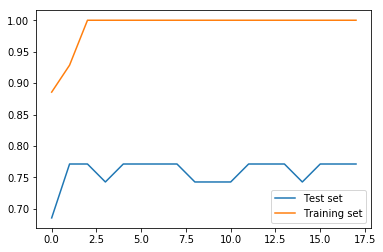

In [624]:
plt.plot(accuracy_test,label="Test set")
plt.plot(accuracy_train,label="Training set")
plt.legend()

As we can see on the representation above, when the number of neighbors increases the train accuracy and test accuracy don't grow together but stay identical.

## Decision Tree with Kmeans labels

In [625]:
data=sort_datatri2.drop(labels='classe', axis=1)
data_train, data_test, label_train, label_test = train_test_split(data, classes2, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes2)))
dt = DecisionTreeClassifier(max_depth=3,criterion="entropy")
dt = dt.fit(data_train,label_train)
tree_predict=dt.predict(data_test)

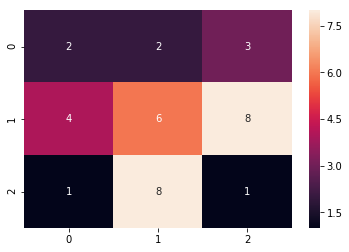

In [626]:
cm3 = metrics.confusion_matrix(label_test, tree_predict)
cm3.shape
cmdf3 = pd.DataFrame(data=cm3, copy=True,index=sortedLabelList,columns=sortedLabelList).loc[sortedLabelList,sortedLabelList]
cmdf3 = cmdf3.transpose()
sns.heatmap(cmdf3, annot=True)

In [627]:
metrics.accuracy_score(label_test,tree_predict)

0.2571428571428571

The accuracy score is very low (<0.5) which means our algorithm is not bette than performing a random classification. As the confusion matric shows, the predicted classes are not really close to the real classes.

#### Cross-validation

In [629]:
scoring = ['accuracy', 'precision_weighted',  'recall_weighted',  'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(dt, data, classes2, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.0022831 , 0.00134301, 0.00127792, 0.00136495, 0.00139403,
        0.001436  , 0.00123501, 0.00118423]),
 'score_time': array([0.00240493, 0.00132585, 0.00127506, 0.001616  , 0.00136805,
        0.0038991 , 0.00121689, 0.00121498]),
 'test_accuracy': array([0.46666667, 0.42857143, 0.35714286, 0.38461538, 0.23076923,
        0.33333333, 0.5       , 0.5       ]),
 'test_f1_weighted': array([0.44574074, 0.35941043, 0.26315789, 0.32307692, 0.21301775,
        0.41666667, 0.44583333, 0.42361111]),
 'test_precision_weighted': array([0.44259259, 0.32251082, 0.20833333, 0.2967033 , 0.1978022 ,
        0.58333333, 0.58333333, 0.41666667]),
 'test_recall_weighted': array([0.46666667, 0.42857143, 0.35714286, 0.38461538, 0.23076923,
        0.33333333, 0.5       , 0.5       ])}

#### Testing overfitting

In [630]:
accuracy_train = []
accuracy_test = []
for i in range(2,20):
    dt = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    dt = dt.fit(data_train,label_train)
    
    tree_predict_train=dt.predict(data_train)
    tree_predict_test=dt.predict(data_test)

    accuracy_train.append(metrics.accuracy_score(label_train,tree_predict_train))
    accuracy_test.append(metrics.accuracy_score(label_test,tree_predict_test))

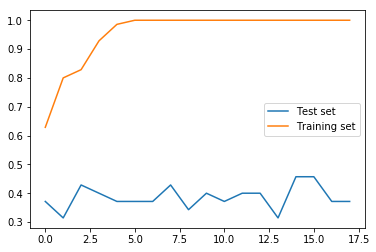

In [631]:
plt.plot(accuracy_test,label="Test set")
plt.plot(accuracy_train,label="Training set")
plt.legend()

Again, it seems that there is an overfitting effect, probably affecting the efficiency of the decision tree algorithm.

### Removing correlated variables 

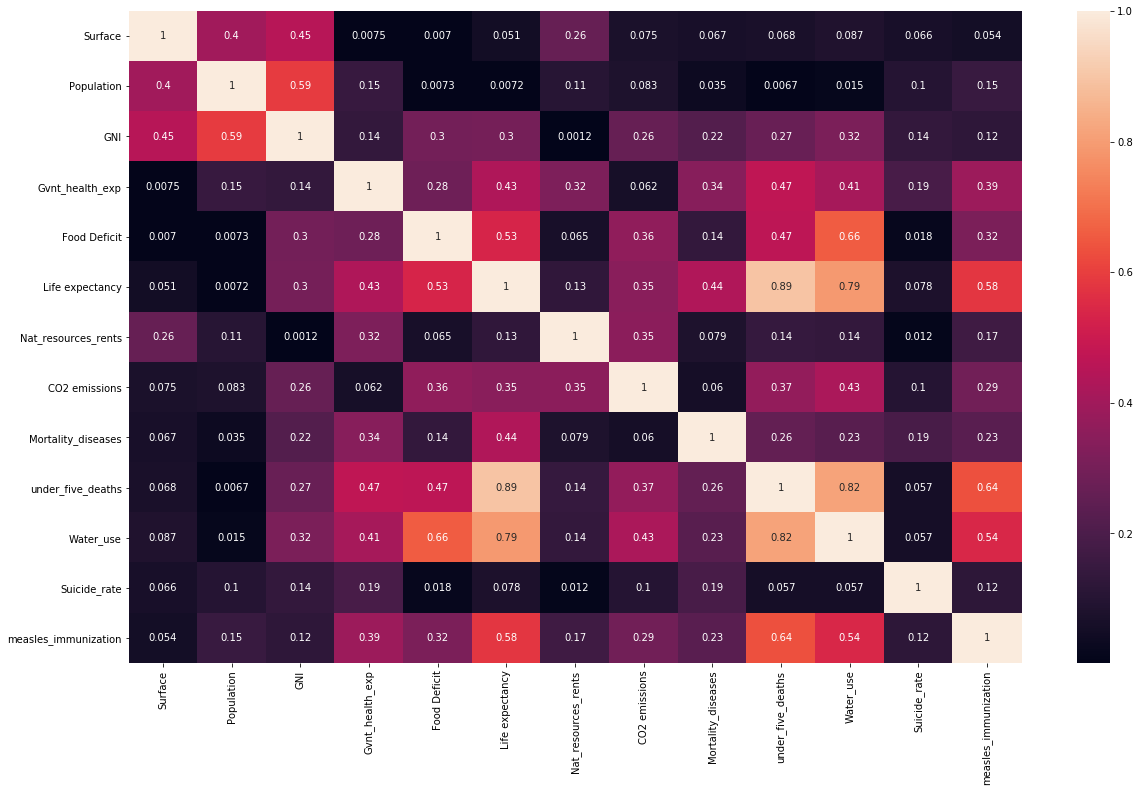

In [632]:
plt.figure(figsize=(20,12))
sns.heatmap(abs(datatri.corr()),annot=True)

In [646]:
abs(datatri.corr()).sum(axis=1)

Surface                 2.599056
Population              2.651511
GNI                     4.098698
Gvnt_health_exp         4.195910
Food Deficit            4.149261
Life expectancy         5.580473
Nat_resources_rents     2.777713
CO2 emissions           3.791472
Mortality_diseases      3.287693
under_five_deaths       5.451294
Water_use               5.483592
Suicide_rate            2.132056
measles_immunization    4.605010
dtype: float64

In [665]:
Z_datatri_copy=Z_datatri.copy()
Z_datatri_copy=Z_datatri_copy.drop(columns=["under_five_deaths"])

In [666]:
kmeans = KMeans(3)
kmeans = kmeans.fit(Z_datatri_copy.loc[:,"Life expectancy"].values.reshape(-1, 1))
classes3 = kmeans.predict(Z_datatri_copy.loc[:,"Life expectancy"].values.reshape(-1, 1)).astype(str) 
Z_datatri_copy=Z_datatri_copy.drop(columns=['Life expectancy'])

In [667]:
Z_datatri_copy.head()

,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Nat_resources_rents,CO2 emissions,Mortality_diseases,Water_use,Suicide_rate,measles_immunization
Country Code,,,,,,,,,,,
AFG,0.219484,0.101605,-0.410814,-1.418325,0.625311,-0.865879,-0.498462,1.972952,-1.578273,-0.496982,-1.741775
AGO,1.138473,-0.036307,-0.102297,-0.941237,0.516886,2.310478,-0.337357,-0.643968,-2.127462,-0.395754,-1.368080
ARE,-0.661465,-0.419495,1.034527,0.073326,-0.856504,0.779974,2.750527,-0.643968,1.148335,-0.851281,0.649873
ARG,3.511927,0.416835,1.664686,0.826323,-1.157686,-0.666436,0.225086,-0.701694,1.137553,0.110387,0.724612
ARM,-0.744815,-0.556375,-0.443968,-0.422274,-0.760126,-0.678535,-0.299656,0.856913,1.038407,-0.345140,0.874090


We decided to remove "under_five_deaths", as it was strongly correlated to Food deficit, water use and measles immunization.

## Decision Tree with Kmeans labels

In [668]:
data_train, data_test, label_train, label_test = train_test_split(Z_datatri_copy, classes3, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes3)))
dt = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt = dt.fit(data_train,label_train)
tree_predict=dt.predict(data_test)

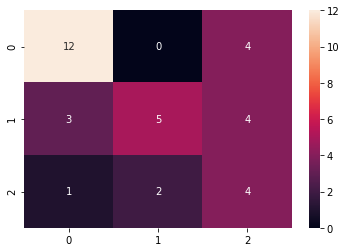

In [669]:
cm4 = metrics.confusion_matrix(label_test, tree_predict)
cm4.shape
cmdf4 = pd.DataFrame(data=cm4, copy=True,index=sortedLabelList,columns=sortedLabelList).loc[sortedLabelList,sortedLabelList]
cmdf4 = cmdf4.transpose()
sns.heatmap(cmdf4, annot=True)

In [670]:
metrics.accuracy_score(label_test,tree_predict)

0.6

With the removal of "under five deaths" variable, the algorithm can't really discriminate 3 different groups, as we can see on the confusion matrix.

#### Cross-validation

In [674]:
scoring = ['accuracy', 'precision_weighted',  'recall_weighted',  'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(dt, Z_datatri_copy, classes3, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00151396, 0.00149488, 0.00118089, 0.00132704, 0.00142503,
        0.00156403, 0.00122404, 0.0013001 ]),
 'score_time': array([0.00173807, 0.00240302, 0.00188303, 0.00155616, 0.00148487,
        0.00134492, 0.00126386, 0.00178981]),
 'test_accuracy': array([0.66666667, 0.57142857, 0.71428571, 0.69230769, 0.61538462,
        0.75      , 0.66666667, 0.75      ]),
 'test_f1_weighted': array([0.67412587, 0.53571429, 0.72684458, 0.66025641, 0.60716634,
        0.76010101, 0.62820513, 0.6952381 ]),
 'test_precision_weighted': array([0.68888889, 0.62987013, 0.75      , 0.67692308, 0.68351648,
        0.78333333, 0.5952381 , 0.81944444]),
 'test_recall_weighted': array([0.66666667, 0.57142857, 0.71428571, 0.69230769, 0.61538462,
        0.75      , 0.66666667, 0.75      ])}

#### Testing overfitting

In [675]:
accuracy_train = []
accuracy_test = []
for i in range(2,20):
    dt = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    dt = dt.fit(data_train,label_train)
    
    tree_predict_train=dt.predict(data_train)
    tree_predict_test=dt.predict(data_test)

    accuracy_train.append(metrics.accuracy_score(label_train,tree_predict_train))
    accuracy_test.append(metrics.accuracy_score(label_test,tree_predict_test))

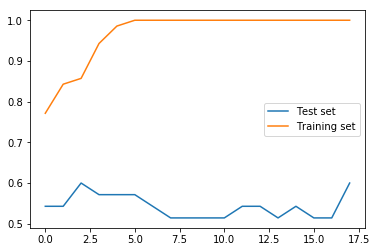

In [676]:
plt.plot(accuracy_test,label="Test set")
plt.plot(accuracy_train,label="Training set")
plt.legend()

After removing the "under five deaths" variable, we can see that there is still an overfitting effect, and that the accuracy remains in the same range (always between 0.5 and 0.6).